In [ ]:
!pip install simpletransformers

In [ ]:
!pip install torchvision 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/TEXT MINING/DATASET/drugsCom_raw.zip" -d "/content"

Archive:  /content/drive/MyDrive/Colab Notebooks/TEXT MINING/DATASET/drugsCom_raw.zip
  inflating: /content/drugsComTest_raw.tsv  
  inflating: /content/drugsComTrain_raw.tsv  


# **Load Library**

In [ ]:
import numpy as np 
from numpy import savetxt, asarray
import pandas as pd 
from IPython.display import display
import seaborn as sns
from scipy import stats
import re
import string
import random

# MATPLOTLIB 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# SKLEARN
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# NLTK
import nltk
from nltk.tokenize import WordPunctTokenizer, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

seed = np.random.RandomState(126)

In [ ]:
data = pd.read_csv ('/content/drugsComTrain_raw.tsv', header=0, sep='\t')
#data.head

# **Text preprocessing**

In [ ]:
#clean dataset
data = data.dropna()
data = data.drop_duplicates(subset=['review'], ignore_index=True)

In [ ]:
data['review'] = data['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))


In [ ]:
df=data

In [ ]:
df['review'] = df['review'].str.replace('[^\w\s]', "")
df['review'] = df['review'].str.replace("&#039;", "")
df['review'] = df['review'].str.replace("[\d-]", "")
df['review'] = df['review'].str.replace("[^\w\s]", "") 
df['review'] = df['review'].str.replace(r'/^\s+|\s+$|\s+(?=\s)/g', '')
df['review'] = df['review'].str.replace(r'\s+',' ')
#df.review.head()

In [ ]:
df.drop_duplicates(subset=['review'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111968 entries, 0 to 112104
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   111968 non-null  int64  
 1   drugName     111968 non-null  object 
 2   condition    111968 non-null  object 
 3   review       111968 non-null  object 
 4   rating       111968 non-null  float64
 5   date         111968 non-null  object 
 6   usefulCount  111968 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.8+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


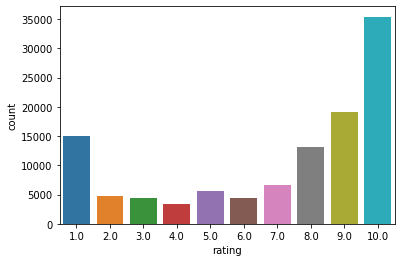

In [ ]:
sns.countplot(df.rating)

In [ ]:
df['rating'].value_counts()

10.0    35394
9.0     19086
1.0     15055
8.0     13164
7.0      6604
5.0      5565
2.0      4786
3.0      4467
6.0      4398
4.0      3449
Name: rating, dtype: int64

# **Build BERT Model**

In [ ]:
train,eva = train_test_split(df,test_size = 0.2)

In [ ]:
import torch
import torchvision

In [ ]:
from simpletransformers.classification import ClassificationModel

In [ ]:
df['sentiment'] = df['rating'].apply(lambda x: 0 if x>5 else (1 if x<5 else 2) )
df.head(3)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,it has no side effect i take it in combination...,9.0,"May 20, 2012",27,0
1,95260,Guanfacine,ADHD,my son is halfway through his fourth week of i...,8.0,"April 27, 2010",192,0
2,92703,Lybrel,Birth Control,i used to take another oral contraceptive whic...,5.0,"December 14, 2009",17,2


In [ ]:
model = ClassificationModel('bert', 'bert-base-cased', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=False)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [ ]:
len(df)

111968

In [ ]:
df_0 = df[df.sentiment == 0].sample(5300)
df_1 = df[df.sentiment == 1].sample(5300)
df_2 = df[df.sentiment == 2].sample(5300)

train_df = pd.concat([df_0, df_1, df_2])

train_df = shuffle(train_df)

In [ ]:
df_0_ = df[df.sentiment == 0].sample(265)
df_1_ = df[df.sentiment == 1].sample(265)
df_2_ = df[df.sentiment == 2].sample(265)

eval_df = pd.concat([df_0_, df_1_, df_2_])

eval_df = shuffle(eval_df)

In [ ]:
Train = pd.DataFrame({
    'text': train_df['review'].replace(r'\n', ' ', regex=True),
    'label': train_df['sentiment']
})

Eval = pd.DataFrame({
    'text': eval_df['review'].replace(r'\n', ' ', regex=True),
    'label': eval_df['sentiment']
})

In [ ]:
model.train_model(Train)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:449: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/15900 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/1988 [00:00<?, ?it/s]

(1988, 0.8699254720083904)

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(Eval)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1029: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/795 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
result

{'eval_loss': 0.695812059044838, 'mcc': 0.5452485723579766}

In [ ]:
model_outputs

array([[-1.28872836,  0.78518689,  0.97543103],
       [-0.21100903, -0.07403567,  1.09341049],
       [-1.75308132,  1.10817206,  0.55628687],
       ...,
       [ 1.88594365, -0.92040956,  0.7493912 ],
       [-1.32516563,  0.67842829,  1.13983798],
       [ 3.10722828, -2.09227848, -0.52650774]])

In [ ]:
lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))

In [ ]:
true = Eval['label'].tolist()
predicted = lst

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(true,predicted)

0.6955974842767295

In [ ]:
print(sklearn.metrics.classification_report(true,predicted,target_names=['positive','neutral','negative']))

              precision    recall  f1-score   support

    positive       0.82      0.74      0.78       265
     neutral       0.71      0.67      0.69       265
    negative       0.59      0.68      0.63       265

    accuracy                           0.70       795
   macro avg       0.71      0.70      0.70       795
weighted avg       0.71      0.70      0.70       795



In [ ]:
def get_result(statement):
    result = model.predict([statement])
    pos = np.where(result[1][0] == np.amax(result[1][0]))
    pos = int(pos[0])
    sentiment_dict = {0:'positive',1:'negative',2:'neutral'}
    print(sentiment_dict[pos])
    return